In [2]:
from dottamine import dotim
import numpy as np
import skimage as sk
import cv2
from scipy.ndimage import distance_transform_edt, convolve, label
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from skimage.feature import peak_local_max
from copy import copy
from skimage.segmentation import watershed
from collections import deque
from skimage.filters import sobel

In [3]:
image = sk.io.imread('./../ppujol/DomesN2V/70_denoised.tif')
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

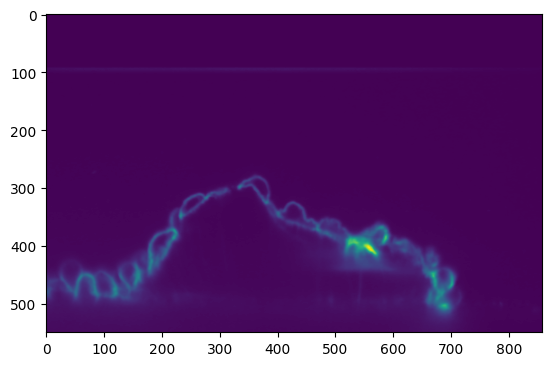

In [4]:
plt.imshow(image[300])

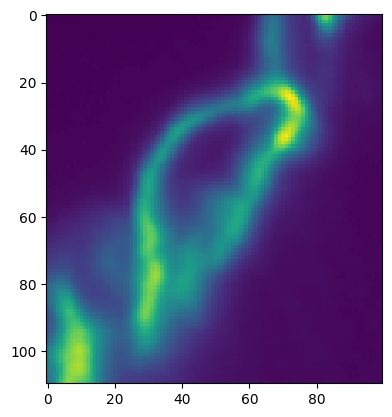

In [38]:
cell = image[220:370, 350:460, 150:250]
# cell = image[270:300, 320:350, 390:420]
# cell = image[270:290, 320:340, 390:410]

# cell = image[260:340]
plt.imshow(cell[80])

In [6]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

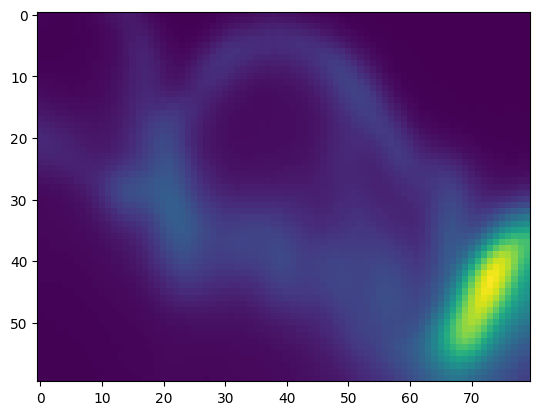

In [486]:
fil = np.array([[[-1,-1,-1],
                 [-1,-1,-1],
                 [-1,-1,-1]],
                [[-1,-1,-1],
                 [-1, 8,-1],
                 [-1,-1,-1]],
                 [[-1,-1,-1],
                 [-1,-1,-1],
                 [-1,-1,-1]]])
cell_border = convolve(cell, fil)
cell_border = reverse_values(cell_border)
cell_border = normalize_image(cell_border, 255).astype(np.uint16)
plt.imshow(cell_border[10])

In [505]:
import tifffile as tiff
tiff.imwrite('./../ppujol/good_single_cell.tif', normalize_image(cell, 255).astype(np.uint16), imagej=True)

In [252]:
seed_point = (40, 35, 40)

In [7]:
def get_neighbors(depth, height, width, pixel):
    return np.mgrid[
         max(0, pixel[0] - 1):min(depth, pixel[0] + 2),
         max(0, pixel[1] - 1):min(height, pixel[1] + 2),
         max(0, pixel[2] - 1):min(width, pixel[2] + 2),
         ].reshape(3, -1).T

def get_neighbors_2d(height, width, pixel):
    return np.mgrid[
         max(0, pixel[0] - 1):min(height, pixel[0] + 2),
         max(0, pixel[1] - 1):min(width, pixel[1] + 2),
         ].reshape(2, -1).T

In [420]:
# Find the indices of the minimum intensity pixel
# min_index = np.unravel_index(np.argmin(cell_border), cell_border.shape)
# min_intensity = np.min(cell_border)
# print(f"Minimum intensity pixel at index {min_index} has value {min_intensity}.")

## watershed
depth, height, width = cell_border.shape
pixels = np.mgrid[0:depth, 0:height, 0:width].reshape(3, -1).T
# neighbours = [get_neighbors(depth, height, width, p) for p in pixels]

neighbours = [[[get_neighbors(depth, height, width, (p,p1,p2)) for p2 in range(width)] for p1 in range(height)] for p in range(depth)]


# print(neighbours)
# print(neighbours[0][0][0])


total = depth*height*width
reshaped_image = cell_border.reshape(total)
indices = np.argsort(reshaped_image)
sorted_image = reshaped_image[indices]
sorted_pixels = pixels[indices]

levels = 10
levels = np.linspace(sorted_image[0], sorted_image[-1], levels)
level_indices = []
current_level = 0

for i in range(total):
    if sorted_image[i] > levels[current_level]:
    # Skip levels until the next highest one is reached.
        while sorted_image[i] > levels[current_level]: current_level += 1
    level_indices.append(i)
level_indices.append(total)

MASK = -2
WSHD = 0
INIT = -1
INQE = -3

current_label = 0

fifo = deque()
flag = False

labels = np.full((depth, height, width), INIT, np.int32)
start_index = 0
for stop_index in level_indices:
    # Mask all pixels at the current level.
    for p in sorted_pixels[start_index:stop_index]:
        labels[p[0], p[1], p[2]] = MASK
        # Initialize queue with neighbours of existing basins at the current level.
        for q in neighbours[p[0]][p[1]][p[2]]:
            # p == q is ignored here because labels[p] < WSHD
            if labels[q[0]][q[1]][q[2]] >= WSHD:
                labels[p[0]][p[1]][p[2]] = INQE
                fifo.append(p)
                break


    # Extend basins.
    while fifo:
        p = fifo.popleft()
        # Label p by inspecting neighbours.
        for q in neighbours[p[0]][p[1]][p[2]]:
            # Don't set lab_p in the outer loop because it may change.
            lab_p = labels[p[0]][p[1]][p[2]]
            lab_q = labels[q[0]][q[1]][q[2]]
            if lab_q > 0:
                if lab_p == INQE or (lab_p == WSHD and flag):
                    labels[p[0]][p[1]][p[2]] = lab_q
                elif lab_p > 0 and lab_p != lab_q:
                    labels[p[0]][p[1]][p[2]] = WSHD
                    flag = False
            elif lab_q == WSHD:
                if lab_p == INQE:
                    labels[p[0]][p[1]][p[2]] = WSHD
                    flag = True
            elif lab_q == MASK:
                labels[q[0]][q[1]][q[2]] = INQE
                fifo.append(q)

    # Detect and process new minima at the current level.
    for p in sorted_pixels[start_index:stop_index]:
        # p is inside a new minimum. Create a new label.
        if labels[p[0]][p[1]][p[2]] == MASK:
            current_label += 1
            fifo.append(p)
            labels[p[0]][p[1]][p[2]] = current_label
            while fifo:
                q = fifo.popleft()
                for r in neighbours[q[0]][q[1]][q[2]]:
                    if labels[r[0]][r[1]][r[2]] == MASK:
                        fifo.append(r)
                        labels[r[0]][r[1]][r[2]] = current_label

    start_index = stop_index

In [15]:
cell = sk.io.imread('./../ppujol/good_single_cell.tif')

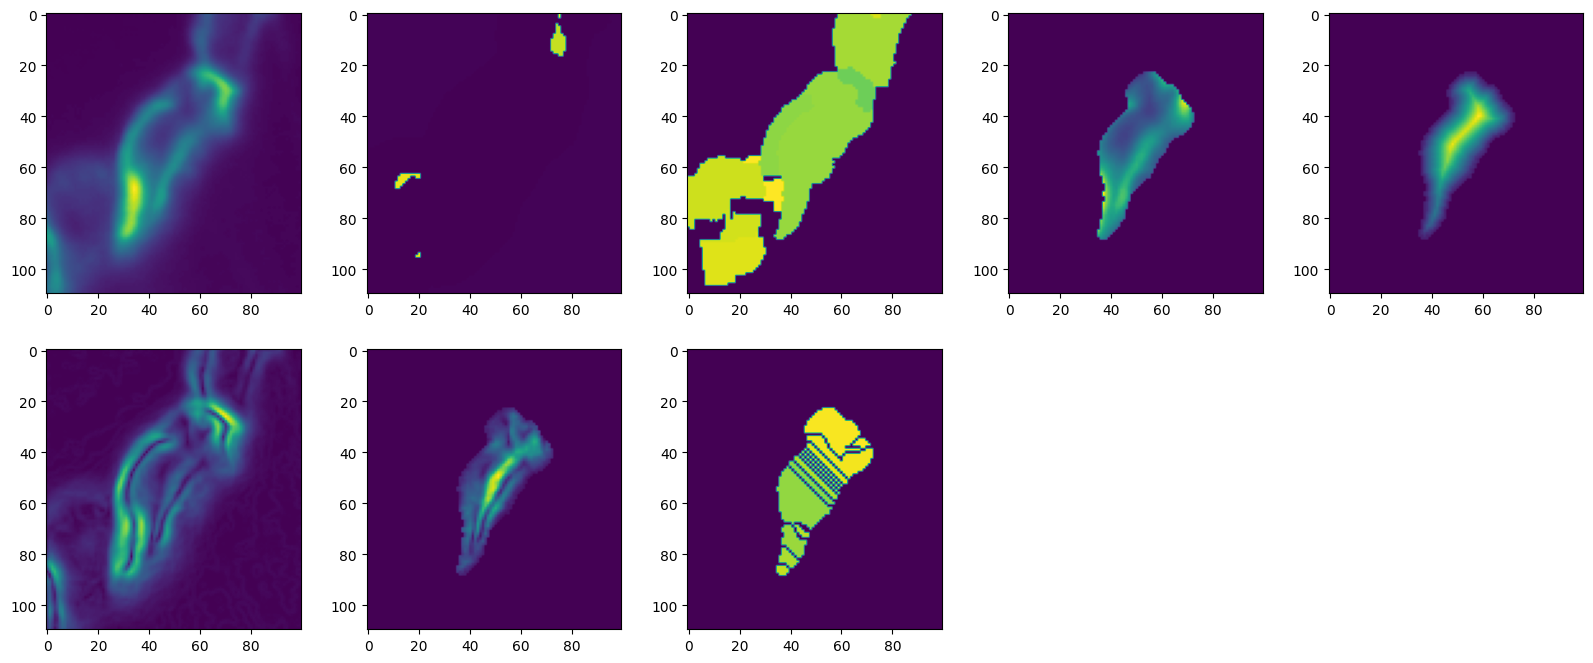

In [39]:
from skimage.morphology import disk, ball
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

y = 90

# image = normalize_image(image, 255).astype(np.uint16)
cell = normalize_image(cell, 255).astype(np.uint16)
cell_border = cell

denoised = rank.median(cell_border, ball(3))
# denoised = rank.median(denoised, disk(2))
# denoised = rank.median(denoised, disk(2))

markers = rank.gradient(denoised, ball(5)) < 10
markers = ndi.label(markers)[0]

gradient = rank.gradient(denoised, ball(2))
labels = watershed(gradient, markers)

plt.figure(figsize=(20,8))
plt.subplot(251)
plt.imshow(cell_border[y])
plt.subplot(252)
plt.imshow(markers[y])    
plt.subplot(253)
plt.imshow(labels[y])

seed_point = (80, 50, 60)

labels[labels != labels[seed_point]] = 0

labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))


maskImage = labels*cell_border
plt.subplot(254)
plt.imshow(maskImage[y])


edt = ndi.distance_transform_edt(maskImage)
plt.subplot(255)
plt.imshow(edt[y])

edge_scharr = sk.filters.scharr(cell_border)
plt.subplot(256)
plt.imshow(edge_scharr[y])
edge_scharr_cell = edge_scharr*edt
ndi.distance_transform_edt(maskImage)

plt.subplot(257)
plt.imshow(edge_scharr_cell[y])

lab = watershed(-edt, markers=None, mask=labels, watershed_line=True)
plt.subplot(258)
plt.imshow(lab[y])

# Repeat adding CLAHE

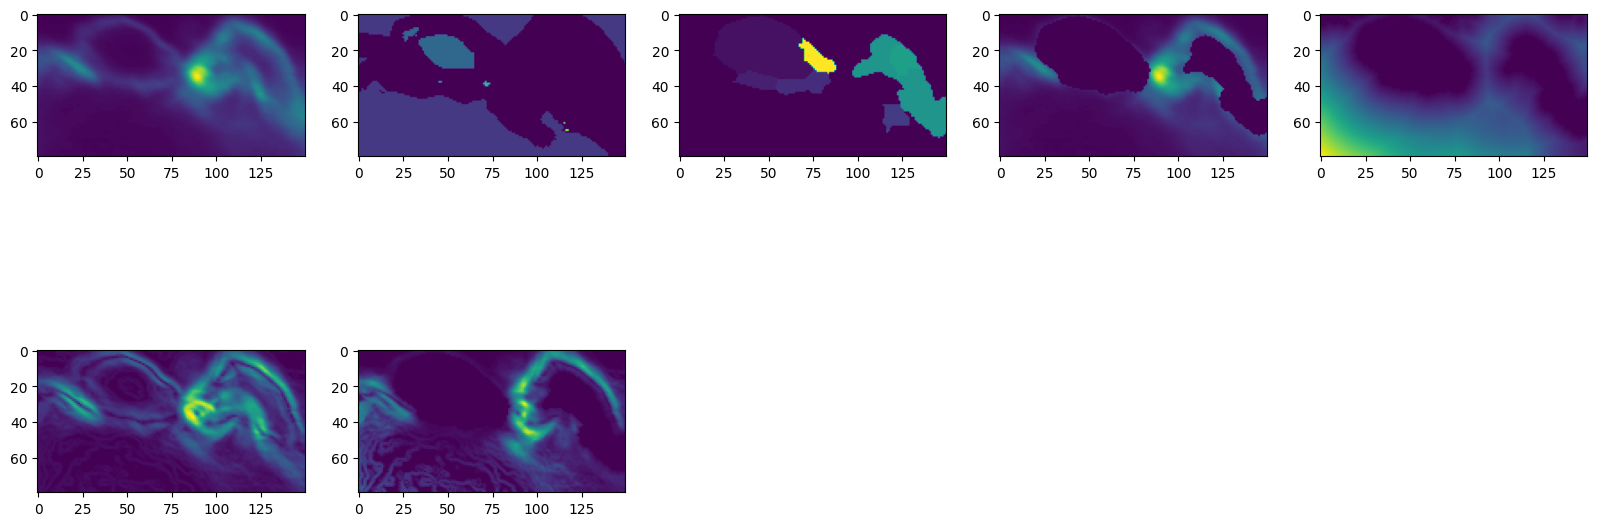

In [20]:
y = 00

# fil = np.array([[[-1,-1,-1],
#                  [-1,-1,-1],
#                  [-1,-1,-1]],
#                 [[-1,-1,-1],
#                  [-1, 8,-1],
#                  [-1,-1,-1]],
#                  [[-1,-1,-1],
#                  [-1,-1,-1],
#                  [-1,-1,-1]]])
# cell_border = convolve(cell, fil)
# cell_border = reverse_values(cell_border)
# cell_border = normalize_image(cell_border, 255).astype(np.uint16)

cell_border = np.transpose(cell, axes=(2, 1, 0))

denoised = rank.median(cell_border, ball(3))
# denoised = rank.median(denoised, disk(2))
# denoised = rank.median(denoised, disk(2))

markers = rank.gradient(denoised, ball(5)) < 10
markers = ndi.label(markers)[0]

gradient = rank.gradient(denoised, ball(2))
labels = watershed(gradient, markers)

plt.figure(figsize=(20,8))
plt.subplot(251)
plt.imshow(cell_border[y])
plt.subplot(252)
plt.imshow(markers[y])    
plt.subplot(253)
plt.imshow(labels[y])

seed_point = (40, 40, 40)

labels[labels != labels[seed_point]] = 0

labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))


maskImage = labels*cell_border
plt.subplot(254)
plt.imshow(maskImage[y])


edt = ndi.distance_transform_edt(maskImage)
plt.subplot(255)
plt.imshow(edt[y])

edge_scharr = sk.filters.scharr(cell_border)
plt.subplot(256)
plt.imshow(edge_scharr[y])
edge_scharr_cell = edge_scharr*edt
ndi.distance_transform_edt(maskImage)

plt.subplot(257)
plt.imshow(edge_scharr_cell[y])

In [41]:
import tifffile as tiff
tiff.imwrite('./../ppujol/single_cell/edt_single_cell_more_y_3.tif', normalize_image(edt, 255).astype(np.uint16), imagej=True)

My watershed:

- Find the minimum
- Increase a given value to the minimum and all 

In [321]:
test = np.array([[3,3,3,4,4],
                 [4,2,1,4,5],
                 [4,3,5,5,5],
                 [4,5,5,2,5],
                 [5,5,4,4,4]])


min_index = np.unravel_index(np.argmin(test), test.shape)
min_intensity = np.min(test)
print(f"Minimum intensity pixel at index {min_index} has value {min_intensity}.")

checked_coords = []
checked_coords.append(min_index)

# print(get_neighbors_2d(*test.shape, min_index))

# test[1,2] += 10
neigh = get_neighbors_2d(*test.shape, min_index)
# print(neigh)
for i in neigh:
    test[i[0], i[1]] += 1

print(test)




Minimum intensity pixel at index (1, 2) has value 1.
[[3 4 4 5 4]
 [4 3 2 5 5]
 [4 4 6 6 5]
 [4 5 5 2 5]
 [5 5 4 4 4]]
